# Проект по курсу "Машинное обучение для текстов"

**Описание проекта**

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

**Цель проекта**

Обучить модель классифицировать комментарии на позитивные и негативные, модель должна быть со значением метрики качества F1 не меньше 0.75.

**Задачи проекта**

- Изучить и очистить данные;
- Подобрать параметры для токенизаторов и моделей с Gridsearch;
- Выбрать лучшую модель и сделать предсказание на тестовой выборке;

## Устанавливаем пакеты и импортируем библиотеки

In [1]:
!pip install emoji -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 6.7 MB/s eta 0:00:00


In [62]:
import pandas as pd
import numpy as np
import re
from time import time
from pprint import pprint
import emoji
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='whitegrid', palette='muted')
RANDOM_STATE = 42
TEST_SIZE = 0.2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Загрузим данные

In [3]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv')
except:
    df = pd.read_csv('toxic_comments.csv')

df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


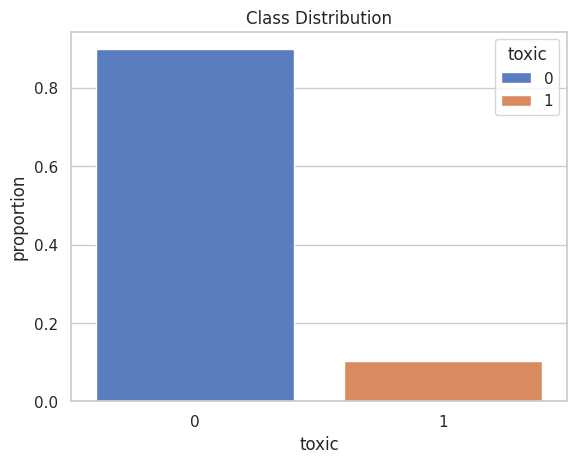

In [11]:
sns.barplot(data=df.toxic.value_counts(normalize=True).reset_index(),
              x='toxic', y='proportion', hue='toxic')
plt.title('Class Distribution')
plt.show()

В датасете классы распределены неравномерно, поэтому при создании выборок необходимо стратифицировать данные.

## Проведем EDA

*   `count_words`: количество слов
*   `count_excl_quest_marks`: количество вопросительных и восклицательных слов
*   `count_capital_words`: количество слов в верхнем регистре (иногда с помощью них выражают эмоции)
*   `count_urls`: количество ссылок
*   `count_emails`: количество эмейлов
*   `count_emojis`: количество эмоджи

In [12]:
class TextCounts(BaseEstimator, TransformerMixin):

    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x))
        #count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        #count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        count_emails = X.apply(lambda x: self.count_regex(r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}", x))
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))

        df = pd.DataFrame({'count_words': count_words
                           #, 'count_mentions': count_mentions
                           #, 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emails': count_emails
                           , 'count_emojis': count_emojis
                          })

        return df
tc = TextCounts()
eda_df = tc.fit_transform(df.text)
eda_df['sentiment'] = df.toxic

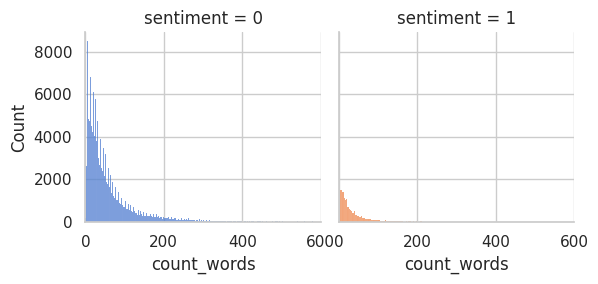

In [33]:
g = sns.FacetGrid(eda_df, col='sentiment',hue='sentiment')
g = g.map(sns.histplot,'count_words')
plt.xlim([0, 600])
plt.show()

In [19]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('sentiment')[col].describe())
    grouped_df = eda_df.groupby('sentiment')[col].sum().reset_index()
    sns.barplot(data=grouped_df, x='sentiment', y=col, hue='sentiment')
    plt.title(f"{col} Distribution")
    plt.show()

Descriptive stats for count_emojis
----------------------------------
              count      mean       std  min  25%  50%  75%   max
sentiment                                                        
0          143106.0  0.012592  0.182481  0.0  0.0  0.0  0.0  17.0
1           16186.0  0.006425  0.178784  0.0  0.0  0.0  0.0  16.0


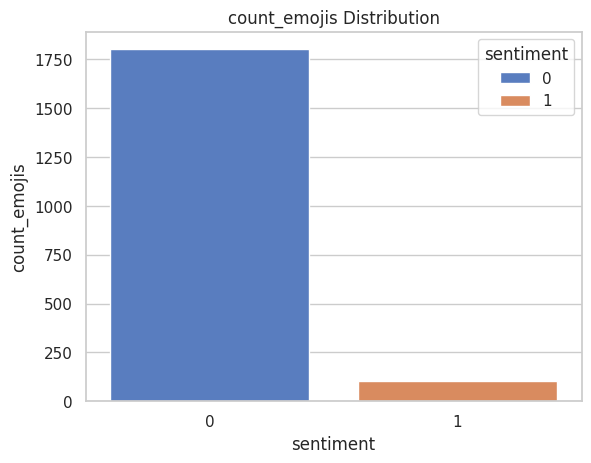

In [20]:
show_dist(eda_df, 'count_emojis')

Descriptive stats for count_emails
----------------------------------
              count      mean       std  min  25%  50%  75%   max
sentiment                                                        
0          143106.0  0.003186  0.081157  0.0  0.0  0.0  0.0  12.0
1           16186.0  0.000865  0.031430  0.0  0.0  0.0  0.0   2.0


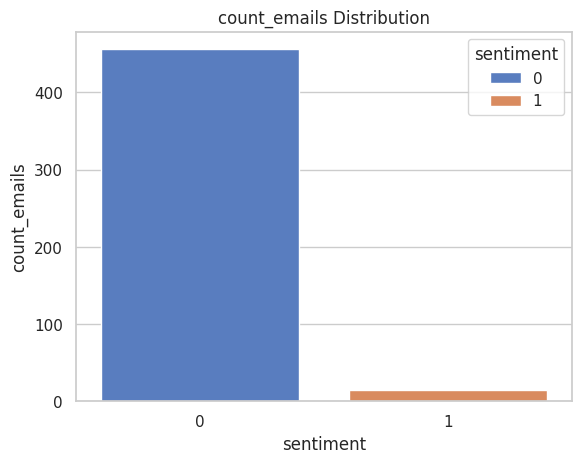

In [21]:
show_dist(eda_df, 'count_emails')

Descriptive stats for count_urls
--------------------------------
              count      mean       std  min  25%  50%  75%   max
sentiment                                                        
0          143106.0  0.049537  0.414052  0.0  0.0  0.0  0.0  31.0
1           16186.0  0.018658  0.197976  0.0  0.0  0.0  0.0   7.0


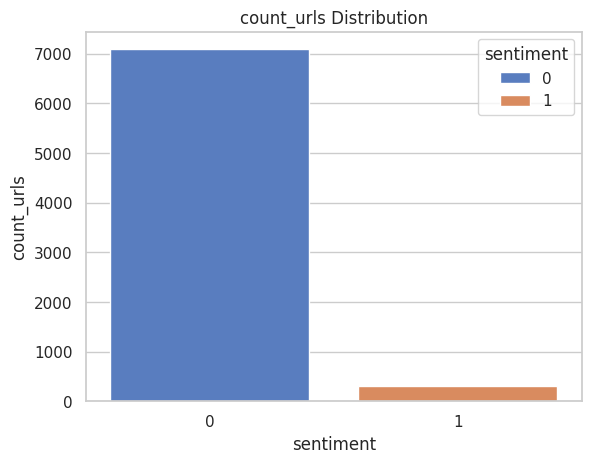

In [22]:
show_dist(eda_df, 'count_urls')

Descriptive stats for count_excl_quest_marks
--------------------------------------------
              count      mean        std  min  25%  50%  75%     max
sentiment                                                           
0          143106.0  0.776816  10.763189  0.0  0.0  0.0  1.0  2762.0
1           16186.0  4.062647  75.198870  0.0  0.0  0.0  1.0  4942.0


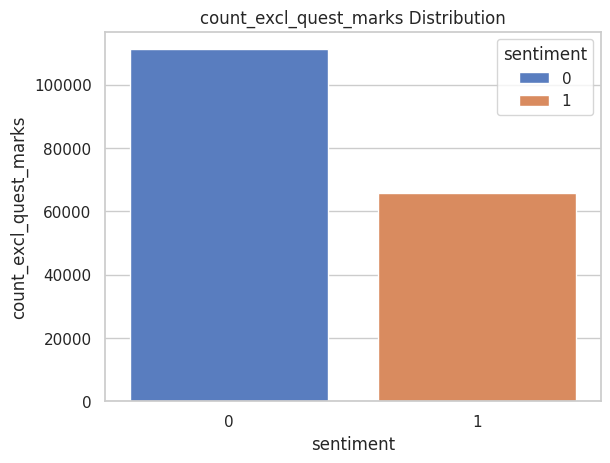

In [23]:
show_dist(eda_df, 'count_excl_quest_marks')

Descriptive stats for count_capital_words
-----------------------------------------
              count      mean        std  min  25%  50%  75%     max
sentiment                                                           
0          143106.0  1.069494   8.387926  0.0  0.0  0.0  1.0  1250.0
1           16186.0  7.517731  57.842928  0.0  0.0  0.0  1.0  1352.0


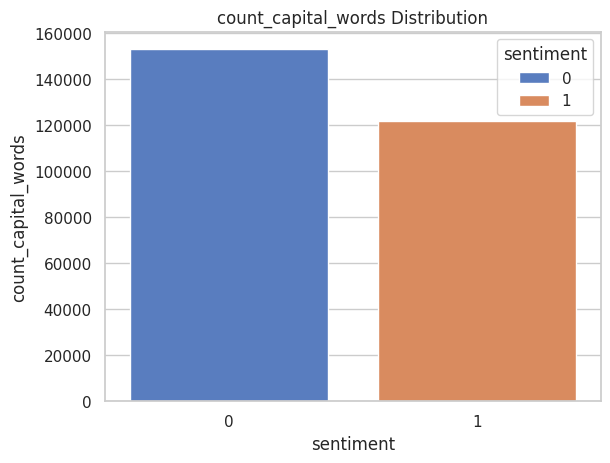

In [24]:
show_dist(eda_df, 'count_capital_words')

- Эмоджи, эмейлы и ссылки часто не используют в негативных комментариях
- Положительные комментарии, кажется, используют чуть больше вопросительных и восклицательных знаков
- В среднем один комментарий содержит 69 слов

## Очистка данных



*   удалим эмейлы и ссылки, так как они не содержат полезной информации
*   удалим знаки препинания и цифры, приведем текст к нижнему регистру
*   удалим стоп-слова


In [34]:
class CleanText(BaseEstimator, TransformerMixin):
    def remove_emails(self, input_text):
        return re.sub(r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}", '', input_text)

    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)

    def emoji_oneword(self, input_text):
        return input_text.replace('_','')

    def remove_punctuation(self, input_text):
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')
        return input_text.translate(trantab)
    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)

    def to_lower(self, input_text):
        return input_text.lower()

    def remove_stopwords(self, input_text):
        whitelist = ["n't", "not", "no"]
        words = input_text.split()
        clean_words = [word for word in words if (word not in stopwords or word in whitelist) and len(word) > 1]
        return " ".join(clean_words)

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_emails).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords)
        return clean_X

In [35]:
ct = CleanText()
sr_clean = ct.fit_transform(df.text)
sr_clean.sample(5)

,text
45483,infobox highlights saw recent edits nba navbox...
47626,according wp competence clearly every editor i...
36762,deaths india hello thank edits india would lik...
27264,md mfd oooh details details get right
71808,page redirect would like page exist instead re...


## Split Data: Train and Test Datasets

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
 sr_clean, df['toxic'],
 test_size=TEST_SIZE,
 random_state=RANDOM_STATE, stratify=df['toxic'])

print(f'Train Set \n{X_train.shape, y_train.shape}')

print(f'Test Set: \n{X_test.shape, y_test.shape}')

Train Set 
((127433,), (127433,))
Test Set: 
((31859,), (31859,))


Мы очистили текст и разделили данные на тренировочную и тестовую выборки.

## Hyperparameter tuning and cross-validation

In [48]:
def grid_vect(model, vector, param_grid):
  pipe = Pipeline([
      ('vect', vector),
      ('model', model)
    ])
  grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='f1')

  print("Performing grid search...")
  print("Pipeline:", [name for name, _ in pipe.steps])
  print("Parameters:")
  pprint(param_grid)
  t0 = time()
  grid_search.fit(X_train, y_train)
  print("done in %0.3fs" % (time() - t0))
  print()
  print("Best CV score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_params_
  for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  return grid_search

## Classifiers

In [50]:
logreg = LogisticRegression(max_iter=1000, penalty='l2')
mnb = MultinomialNB()

## Parameter grids for GridSearchCV



In [53]:
logreg_params = {
    'model__C': (0.5, 1.0)
}

mnb_params = {'model__alpha': (0.25, 0.5, 0.75)}

## CountVectorizer

In [54]:
bow = CountVectorizer(max_df=0.5)

best_logreg_countvect = grid_vect(model=logreg, vector=bow, param_grid=logreg_params)
best_mnb_countvect = grid_vect(model=mnb, vector=bow, param_grid=mnb_params)

Performing grid search...
Pipeline: ['vect', 'model']
Parameters:
{'model__C': (0.5, 1.0)}
done in 242.748s

Best CV score: 0.760
Best parameters set:
	model__C: 1.0
Performing grid search...
Pipeline: ['vect', 'model']
Parameters:
{'model__alpha': (0.25, 0.5, 0.75)}
done in 77.121s

Best CV score: 0.731
Best parameters set:
	model__alpha: 0.25


## TfidfVectorizer

In [55]:
tfidf = TfidfVectorizer(max_df=0.5)

best_logreg_tfidf = grid_vect(model=logreg, vector=tfidf, param_grid=logreg_params)
best_mnb_tfidf = grid_vect(model=mnb, vector=tfidf, param_grid=mnb_params)

Performing grid search...
Pipeline: ['vect', 'model']
Parameters:
{'model__C': (0.5, 1.0)}
done in 96.915s

Best CV score: 0.725
Best parameters set:
	model__C: 1.0
Performing grid search...
Pipeline: ['vect', 'model']
Parameters:
{'model__alpha': (0.25, 0.5, 0.75)}
done in 79.527s

Best CV score: 0.569
Best parameters set:
	model__alpha: 0.25


- Мы выбрали две модели: `LogisticRegression` и `MultinomialNB`. Для каждой подобрали гиперпараметры с `GridSearchCV`
- Текст предложили токенизировать двумя способами: `TfidfVectorizer` и `CountVectorizer`
- Лучшей моделью оказалась логистическая регрессия с `CountVectorizer`.

## Make predictions on Test Dataset

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     28622
           1       0.85      0.69      0.76      3237

    accuracy                           0.96     31859
   macro avg       0.91      0.84      0.87     31859
weighted avg       0.95      0.96      0.95     31859



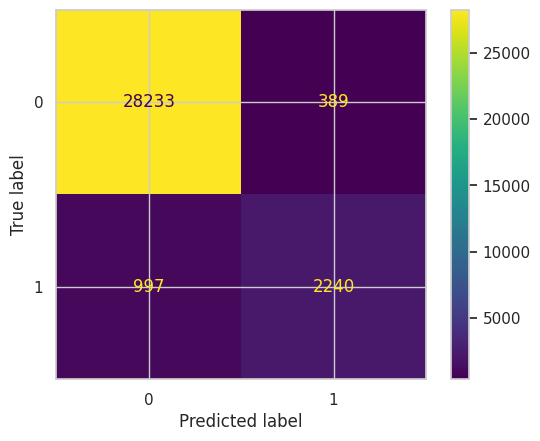

In [63]:
final_preds = best_logreg_countvect.predict(X_test)
print(classification_report(y_test, final_preds))
ConfusionMatrixDisplay.from_estimator(best_logreg_countvect, X_test, y_test)
plt.show()

Видно, что модель работает хорошо, но с существенным перекосом в сторону мажорного класса (класс 0).

Модель очень хорошо предсказывает класс 0 (высокая precision и recall): большинство истинных нулей правильно классифицируется, и лишь небольшая часть предсказанных нулей оказывается ошибочными.

Однако, из всех примеров класса 1 модель корректно классифицирует только 69%.

## Общий вывод

- Мы изучили данные, построили графики распределений некоторых знаков в тексте
- Очистили текст и удалили стоп-слова
- Выбрали создать токены через мешок слов или через TF-IDF
- С помощью GridSearchCV подобрали параметры для моделей `LogisticRegression` и `MultinomialNB`
- Лучшая модель со значением метрики F1 - 0,76